Every feature depends on the team:
- goals scores (at home and away)
- goals conceded (at home and away)
- goal difference
- current ranking
- average ranking in the last 5 seasons for example
- current streak of games (average number of points gained in the last X games)
- head2head (goals scored, conceded, wins, ties...)
- general win/tie/loses rate of each team
- Number of promotions and relegations ?
- biggest win ?
- longest undefeated streak ?
- day and hour ?

In [39]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import warnings

# Imports / Data etc
!wget -q https://github.com/tinchit0/la-quiniela/raw/refs/heads/main/laliga.sqlite -O laliga.db
warnings.filterwarnings("ignore")

conn = sqlite3.connect('laliga.db')
df = pd.read_sql_query("SELECT * FROM Matches", conn)
df = df.dropna(axis = 'index' , how = 'all')
display(df.head())

# Close the connection when done
conn.close()

,season,division,matchday,date,time,home_team,away_team,score
0,1928-1929,1,1,2/10/29,None,Arenas Club,Athletic Madrid,2:3
1,1928-1929,1,1,2/10/29,None,Espanyol,Real Unión,3:2
2,1928-1929,1,1,2/10/29,None,Real Madrid,Catalunya,5:0
3,1928-1929,1,1,2/10/29,None,Donostia,Athletic,1:1
4,1928-1929,1,1,2/12/29,None,Racing,Barcelona,0:2


In [40]:
df = df.loc[(df['season'] >= '2000-2001') & (~df['score'].isnull())]
pd.set_option("display.max_rows", 50)
df

,season,division,matchday,date,time,home_team,away_team,score
17838,2000-2001,1,1,9/9/00,8:15 PM,Real Sociedad,Racing,2:2
17839,2000-2001,1,1,9/9/00,9:00 PM,Real Zaragoza,Espanyol,1:2
17840,2000-2001,1,1,9/9/00,9:00 PM,Barcelona,Málaga CF,2:1
17841,2000-2001,1,1,9/9/00,9:00 PM,Dep. La Coruña,Athletic,2:0
17842,2000-2001,1,1,9/9/00,9:00 PM,Real Madrid,Valencia,2:1
...,...,...,...,...,...,...,...,...
48345,2021-2022,2,3,8/28/21,10:00 PM,Ponferradina,Girona,2:1
48346,2021-2022,2,3,8/29/21,5:00 PM,SD Amorebieta,UD Almería,2:1
48347,2021-2022,2,3,8/29/21,7:30 PM,CD Lugo,Real Valladolid,0:2
48348,2021-2022,2,3,8/29/21,7:30 PM,Real Sociedad B,CF Fuenlabrada,0:0


In [41]:
# Separate the home score and the away score.
df[['home_score', 'away_score']] = df['score'].str.split(':', expand=True)
df['home_score'] = pd.to_numeric(df['home_score'])
df['away_score'] = pd.to_numeric(df['away_score'])


# Calculate home team total goals
home_goals = df.groupby('home_team')['home_score'].sum().reset_index()
home_goals.columns = ['team', 'home_goals']

# Calculate away team total goals
away_goals = df.groupby('away_team')['away_score'].sum().reset_index()
away_goals.columns = ['team', 'away_goals']

# Merge the home and away goals
all_time = pd.merge(home_goals, away_goals, on='team', how='outer').fillna(0)

# Calculate total goals
all_time['total_goals'] = all_time['home_goals'] + all_time['away_goals']

# Calculate total concedes when playing at home
home_conceding = df.groupby('home_team')['away_score'].sum().reset_index()
home_conceding.columns = ['team', 'concedes_home']

# Calculate total concedes when visiting
away_conceding = df.groupby('away_team')['home_score'].sum().reset_index()
away_conceding.columns = ['team', 'concedes_away']

# Calculate total concedes
all_time_concedes = pd.merge(home_conceding, away_conceding, on='team', how='outer').fillna(0)
all_time_concedes['total_concedes'] = all_time_concedes['concedes_home'] + all_time_concedes['concedes_away']
all_time = pd.merge(all_time, all_time_concedes, on='team', how='outer').fillna(0)

home_counts = df['home_team'].value_counts()
away_counts = df['away_team'].value_counts()
total_counts = home_counts.add(away_counts, fill_value=0)
df['home_app_home'] = df['home_team'].map(home_counts)
df['home_app_total'] = df['home_team'].map(total_counts)
df['away_app_away'] = df['away_team'].map(away_counts)
df['away_app_total'] = df['away_team'].map(total_counts)

df = df.merge(all_time[['team','home_goals','total_goals','concedes_home','total_concedes']], left_on='home_team', right_on='team', how='outer').fillna(0)
df = df.merge(all_time[['team','away_goals','total_goals','concedes_away','total_concedes']], left_on='away_team', right_on='team', suffixes=('_home', '_away'), how='outer').fillna(0)
df = df.drop('team_home', axis=1)
df = df.drop('team_away', axis=1)
df = df.sort_values(by='season', ascending=True)

df['home_goals_ratio'] = df['home_goals'] / df['home_app_home']
df['away_goals_ratio'] = df['away_goals'] / df['away_app_away']
df['total_goals_home_ratio'] = df['total_goals_home'] / df['home_app_total']
df['total_goals_away_ratio'] = df['total_goals_away'] / df['away_app_total']

df['concedes_home_ratio'] = df['concedes_home'] / df['home_app_home']
df['concedes_away_ratio'] = df['concedes_away'] / df['away_app_away']
df['total_concedes_home_ratio'] = df['total_concedes_home'] / df['home_app_total']
df['total_concedes_away_ratio'] = df['total_concedes_away'] / df['away_app_total']

#df = df.drop('home_app_home', axis=1)
#df = df.drop('home_app_total', axis=1)
#df = df.drop('away_app_away', axis=1)
#df = df.drop('away_app_total', axis=1)

df['goal_diff_home'] = df['home_goals'] - df['concedes_home']
df['goal_diff_home_total'] = df['total_goals_home'] - df['total_concedes_home']
df['goal_diff_away'] = df['away_goals'] - df['concedes_away']
df['goal_diff_away_total'] = df['total_goals_away'] - df['total_concedes_away']
df['goal_diff_home_ratio'] = df['home_goals_ratio'] - df['concedes_home_ratio']
df['goal_diff_home_total_ratio'] = df['total_goals_home_ratio'] - df['total_concedes_home_ratio']
df['goal_diff_away_ratio'] = df['away_goals_ratio'] - df['concedes_away_ratio']
df['goal_diff_away_total_ratio'] = df['total_goals_away_ratio'] - df['total_concedes_away_ratio']

# Define whether it is a home or away win.
df['result'] = df.apply(lambda row: 0 if row['home_score'] > row['away_score']
                                        else 2 if row['home_score'] < row['away_score']
                                        else 1, axis=1)



# Convert 'date' column to datetime with specified format
df['date'] = pd.to_datetime(df['date'], format='%m/%d/%y')

# Add a 'weekday' column with weekday names
df['weekday'] = df['date'].dt.day_name()
df['weekday_num'] = df['date'].dt.dayofweek


# Convert 'time' column to datetime (adjusting format as "hour:minute AM/PM")
# df['time_absolute'] = pd.to_datetime(df['time'], format='%I:%M %p')

# Extract the hour from the converted 'time' column
# df['hour'] = df['time_absolute'].dt.hour

df = df.drop('weekday', axis=1)


df.head(10)

,season,division,matchday,date,time,home_team,away_team,score,home_score,away_score,...,goal_diff_home,goal_diff_home_total,goal_diff_away,goal_diff_away_total,goal_diff_home_ratio,goal_diff_home_total_ratio,goal_diff_away_ratio,goal_diff_away_total_ratio,result,weekday_num
12420,2000-2001,1,4,2000-10-18,6:00 PM,Espanyol,Real Sociedad,1:2,1,2,...,94,-151,-153,37,0.233831,-0.187578,-0.376847,0.045510,2,2
16916,2000-2001,1,33,2001-05-05,8:15 PM,Real Sociedad,Valencia,1:2,1,2,...,190,37,-30,294,0.466830,0.045510,-0.075000,0.367041,2,5
5713,2000-2001,1,23,2001-02-17,9:00 PM,Barcelona,Dep. La Coruña,2:3,2,3,...,793,1176,-159,-22,1.977556,1.468165,-0.409794,-0.028351,2,5
12864,2000-2001,1,27,2001-03-18,5:00 PM,Espanyol,Real Valladolid,1:0,1,0,...,94,-151,-174,-46,0.233831,-0.187578,-0.415274,-0.054958,0,6
7174,2000-2001,2,35,2001-04-29,0,Levante,Getafe,3:3,3,3,...,107,-121,-223,-100,0.257212,-0.145258,-0.571795,-0.128370,1,6
3141,2000-2001,2,15,2000-12-03,0,Real Betis,CD Leganés,2:1,2,1,...,139,-16,-76,-35,0.339853,-0.019584,-0.339286,-0.077951,0,6
3143,2000-2001,2,13,2000-11-19,0,Real Jaén CF,CD Leganés,0:0,0,0,...,10,-31,-76,-35,0.158730,-0.246032,-0.339286,-0.077951,1,6
15363,2000-2001,2,28,2001-03-10,0,Sevilla FC,Sporting Gijón,1:1,1,1,...,330,272,-148,21,0.820896,0.337888,-0.344186,0.024390,1,5
16934,2000-2001,1,13,2000-12-02,6:00 PM,Real Valladolid,Valencia,0:0,0,0,...,128,-46,-30,294,0.306220,-0.054958,-0.075000,0.367041,1,5
3149,2000-2001,2,24,2001-02-11,0,Real Murcia,CD Leganés,2:2,2,2,...,66,-47,-76,-35,0.245353,-0.087361,-0.339286,-0.077951,1,6


In [42]:
df.corr(numeric_only=True).style.background_gradient("coolwarm", vmin=-1, vmax=1)

,division,matchday,home_score,away_score,home_app_home,home_app_total,away_app_away,away_app_total,home_goals,total_goals_home,concedes_home,total_concedes_home,away_goals,total_goals_away,concedes_away,total_concedes_away,home_goals_ratio,away_goals_ratio,total_goals_home_ratio,total_goals_away_ratio,concedes_home_ratio,concedes_away_ratio,total_concedes_home_ratio,total_concedes_away_ratio,goal_diff_home,goal_diff_home_total,goal_diff_away,goal_diff_away_total,goal_diff_home_ratio,goal_diff_home_total_ratio,goal_diff_away_ratio,goal_diff_away_total_ratio,result,weekday_num
division,1.000000,0.085211,-0.083200,-0.065228,-0.483179,-0.483507,-0.483807,-0.483484,-0.553883,-0.554659,-0.459609,-0.452932,-0.552881,-0.554722,-0.444685,-0.453000,-0.414068,-0.403229,-0.416727,-0.416895,0.077489,0.055914,0.070831,0.071073,-0.431173,-0.306786,-0.102490,-0.306894,-0.378711,-0.356248,-0.310904,-0.356347,0.005106,0.092667
matchday,0.085211,1.000000,0.019390,0.023633,-0.037270,-0.037277,-0.042330,-0.042280,-0.043967,-0.043963,-0.035375,-0.034747,-0.048430,-0.048566,-0.039010,-0.039552,-0.034152,-0.033892,-0.033838,-0.035640,0.007399,0.007291,0.008199,0.008589,-0.035093,-0.025603,-0.008898,-0.026989,-0.031540,-0.029796,-0.027328,-0.031353,-0.002335,0.008426
home_score,-0.083200,0.019390,1.000000,0.013583,0.099718,0.099906,-0.009373,-0.009384,0.213835,0.211971,0.062089,0.056214,-0.040488,-0.040750,0.023066,0.019340,0.270472,-0.055805,0.267079,-0.056226,-0.090012,0.126883,-0.114401,0.119191,0.256637,0.247828,-0.083865,-0.081320,0.259274,0.252810,-0.098021,-0.086853,-0.611825,-0.017427
away_score,-0.065228,0.023633,0.013583,1.000000,-0.020314,-0.020307,0.079721,0.079591,-0.037411,-0.037307,0.005972,0.002315,0.174161,0.172013,0.039855,0.043872,-0.036675,0.225025,-0.036815,0.219642,0.110202,-0.098969,0.097832,-0.095734,-0.058060,-0.057258,0.169854,0.203068,-0.064749,-0.063974,0.204781,0.208372,0.599994,0.001614
home_app_home,-0.483179,-0.037270,0.099718,-0.020314,1.000000,0.999992,0.209174,0.209027,0.848591,0.851579,0.961468,0.963848,0.247325,0.248505,0.193202,0.196827,0.368680,0.187781,0.368757,0.194135,-0.184330,-0.019320,-0.131699,-0.026237,0.459436,0.171081,0.053703,0.144305,0.372028,0.339737,0.141685,0.163511,-0.083776,-0.024694
home_app_total,-0.483507,-0.037277,0.099906,-0.020307,0.999992,1.000000,0.209325,0.209178,0.849015,0.851977,0.961471,0.963864,0.247485,0.248665,0.193335,0.196964,0.369378,0.187883,0.369411,0.194240,-0.184271,-0.019350,-0.131602,-0.026270,0.460038,0.171646,0.053726,0.144387,0.372609,0.340222,0.141771,0.163607,-0.083863,-0.024720
away_app_away,-0.483807,-0.042330,-0.009373,0.079721,0.209174,0.209325,1.000000,0.999992,0.248649,0.248715,0.200039,0.197082,0.851967,0.852304,0.958055,0.963894,0.193528,0.354276,0.194322,0.369963,-0.028559,-0.073869,-0.024934,-0.133029,0.198478,0.144289,-0.216538,0.172293,0.174690,0.163248,0.284580,0.340991,0.062126,-0.046023
away_app_total,-0.483484,-0.042280,-0.009384,0.079591,0.209027,0.209178,0.999992,1.000000,0.248495,0.248561,0.199903,0.196949,0.851617,0.851915,0.958047,0.963895,0.193431,0.353698,0.194225,0.369308,-0.028526,-0.073961,-0.024898,-0.133121,0.198365,0.144212,-0.216978,0.171724,0.174597,0.163157,0.284214,0.340503,0.062052,-0.045980
home_goals,-0.553883,-0.043967,0.213835,-0.037411,0.848591,0.849015,0.248649,0.248495,1.000000,0.998441,0.738520,0.727992,0.278234,0.279207,0.234404,0.238305,0.790598,0.196954,0.789305,0.203577,-0.339478,-0.010557,-0.357933,-0.018835,0.849811,0.649814,0.037002,0.142966,0.780927,0.754177,0.144125,0.168393,-0.144194,-0.042144
total_goals_home,-0.554659,-0.043963,0.211971,-0.037307,0.851579,0.851977,0.248715,0.248561,0.998441,1.000000,0.742282,0.731644,0.278515,0.279525,0.234329,0.238281,0.783707,0.197400,0.789366,0.204164,-0.338532,-0.010711,-0.357304,-0.018749,0.844645,0.648019,0.037466,0.143458,0.774728,0.754002,0.144512,0.168829,-0.142637,-0.041704


In [68]:
target = "result"
features = [
    "division", "matchday", "home_app_home", "home_app_total",
    "away_app_away", "away_app_total", "home_goals", "total_goals_home", "concedes_home",
    "total_concedes_home", "away_goals", "total_goals_away", "concedes_away", "total_concedes_away",
    "home_goals_ratio", "away_goals_ratio", "total_goals_home_ratio", "total_goals_away_ratio",
    "concedes_home_ratio", "concedes_away_ratio", "total_concedes_home_ratio", "total_concedes_away_ratio",
    "goal_diff_home", "goal_diff_home_total", "goal_diff_away", "goal_diff_away_total",
    "goal_diff_home_ratio", "goal_diff_home_total_ratio", "goal_diff_away_ratio", "goal_diff_away_total_ratio",
    "weekday_num"
]
X, y = df[features], df[target]

In [69]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (14195, 31)
X_test shape: (3549, 31)
y_train shape: (14195,)
y_test shape: (3549,)


In [70]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score

gbm_model = GradientBoostingRegressor()
gbm_model.fit(X_train, y_train)
gbm_y_pred = gbm_model.predict(X_test)

print(f"RMSE: {mean_squared_error(y_test, gbm_y_pred)**0.5}")
print(f"MAPE: {mean_absolute_percentage_error(y_test, gbm_y_pred)}")
print(f"R^2: {r2_score(y_test, gbm_y_pred)}")

RMSE: 0.7906236572501525
MAPE: 1512725147246700.5
R^2: 0.08510328431067493


In [83]:


preds_df = df.loc[y_test.index].copy()
preds_df["y_real"] = preds_df[target]  # I'm just adding this column to have both y_real and y_pred at the right of my df
preds_df["y_pred_rounded"] = gbm_y_pred.round(0)
preds_df["y_pred"] = gbm_y_pred
preds_df["err"] = preds_df["y_real"] - preds_df["y_pred"]
preds_df[["y_real","y_pred_rounded","y_pred"]].head(50)

,y_real,y_pred_rounded,y_pred
2609,0,1.0,0.881798
7948,0,1.0,0.927381
14529,0,1.0,0.559734
5287,1,1.0,1.048252
10468,0,1.0,0.553288
16738,2,1.0,1.049493
13875,0,1.0,0.708432
15187,1,1.0,0.916722
13366,2,1.0,0.739495
8266,2,1.0,0.787702


In [72]:
gbm_model.feature_importances_

array([0.00315618, 0.03822941, 0.01188453, 0.00916288, 0.00584684,
       0.01528632, 0.06905635, 0.02327446, 0.01056816, 0.01129966,
       0.0363849 , 0.0136747 , 0.01408945, 0.01761889, 0.04015143,
       0.03470514, 0.01397474, 0.01904621, 0.01465203, 0.01132933,
       0.01292537, 0.00827476, 0.03037228, 0.02373582, 0.05508962,
       0.01120951, 0.20310977, 0.02124235, 0.1494837 , 0.06433859,
       0.00682661])

<Axes: >

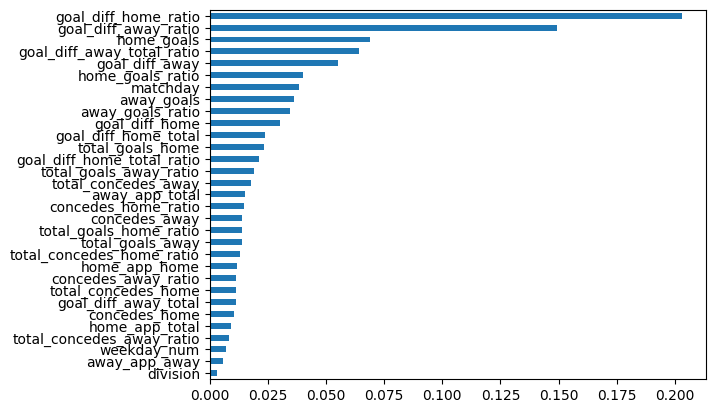

In [73]:
importances = pd.Series(gbm_model.feature_importances_, index=features)
importances.sort_values(ascending=True).plot(kind="barh")